In [42]:
import numpy as np
import pandas as pd
import yfinance as yf
from lppls import lppls, data_loader
from datetime import datetime as dt

from matplotlib import pyplot as plt

In [43]:
ticker = '^GSPC'
start = '2023-01-01'
end = '2023-10-13'
data = yf.download(ticker, start=start, end=end)
data.info()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 196 entries, 2023-01-03 to 2023-10-12
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       196 non-null    float64
 1   High       196 non-null    float64
 2   Low        196 non-null    float64
 3   Close      196 non-null    float64
 4   Adj Close  196 non-null    float64
 5   Volume     196 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 10.7 KB


In [44]:
time = [pd.Timestamp.toordinal(t1) for t1 in (data.index).date]

# create list of observation data
price = np.log(data['Adj Close'].values)

In [45]:
print(len(time))
print(len(price))

196
196


In [46]:
print(type(time))
print(type(price))

<class 'list'>
<class 'numpy.ndarray'>


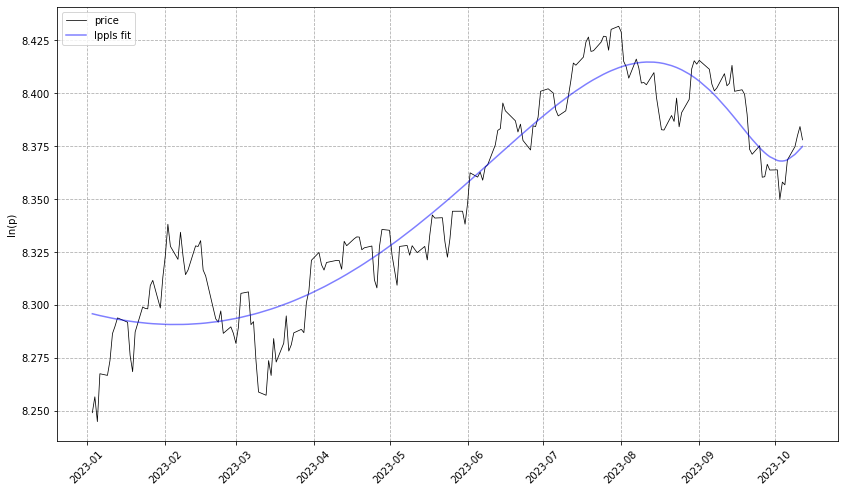

In [47]:
# create observations array (expected format for LPPLS observations)
observations = np.array([time, price])

# set the max number for searches to perform before giving-up
# the literature suggests 25
MAX_SEARCHES = 25

# instantiate a new LPPLS model with the Nasdaq Dot-com bubble dataset
lppls_model = lppls.LPPLS(observations=observations)

# fit the model to the data and get back the params
tc, m, w, a, b, c, c1, c2, O, D = lppls_model.fit(MAX_SEARCHES)

# visualize the fit
lppls_model.plot_fit()

100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [01:19<00:00,  1.03s/it]


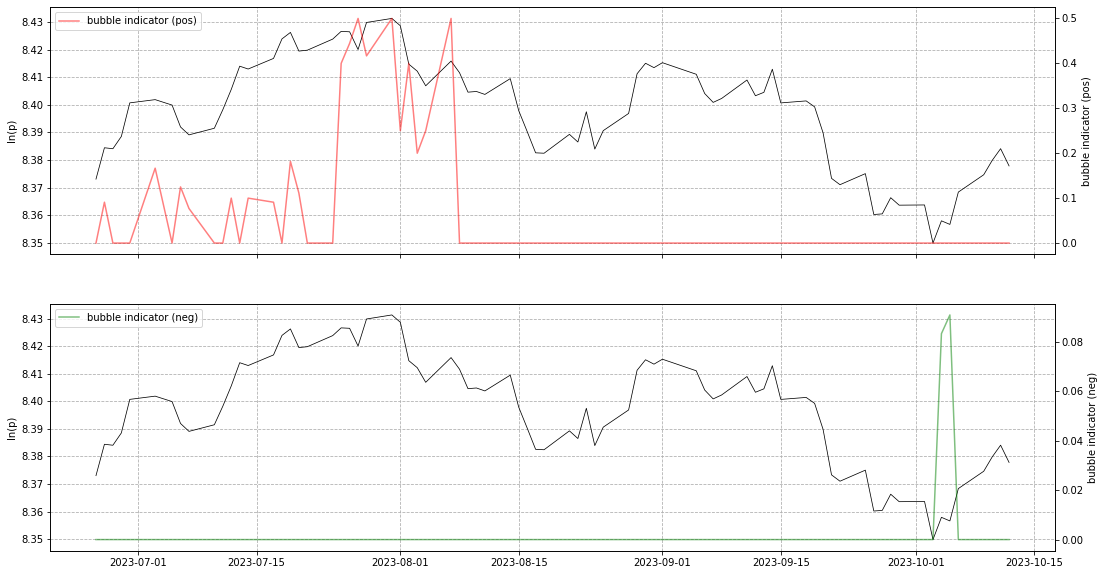

In [48]:
# compute the confidence indicator
res = lppls_model.mp_compute_nested_fits(
    workers=8,
    window_size=120, 
    smallest_window_size=30, 
    outer_increment=1, 
    inner_increment=5, 
    max_searches=25,
    # filter_conditions_config={} # not implemented in 0.6.x
)

lppls_model.plot_confidence_indicators(res)
# should give a plot like the following...

In [49]:
res_df = lppls_model.compute_indicators(res)

In [50]:
pos_indices = np.array(res_df[res_df['pos_conf'] > 0.0].time).astype(int)
neg_indices = np.array(res_df[res_df['neg_conf'] > 0.0].time).astype(int)

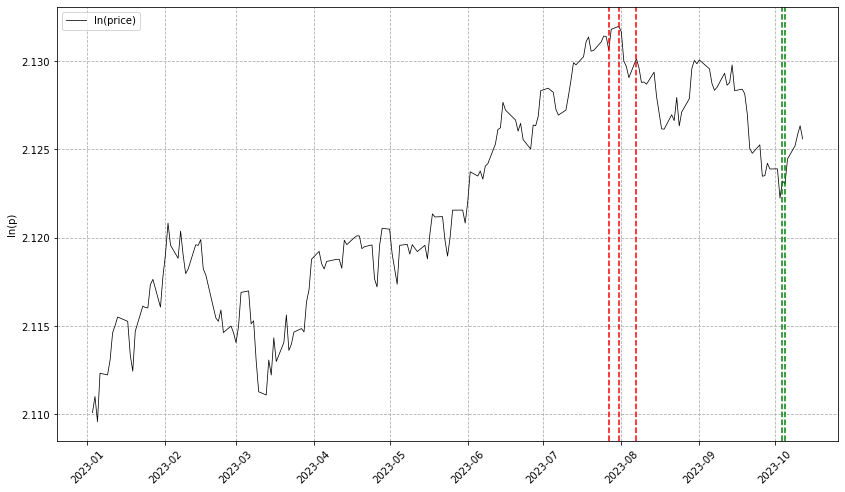

In [105]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(14, 8))


timestamps = [pd.Timestamp.fromordinal(ordinal) for ordinal in time]

#plot log of price
ax1.plot(timestamps , np.log(price), label='ln(price)', color='black', linewidth=0.75)
ax1.grid(which='major', axis='both', linestyle='--')

# set labels
ax1.set_ylabel('ln(p)')
ax1.legend(loc=2)

# plot confidence poins
for x in pos_indices:
    cof_time = pd.Timestamp.fromordinal(x)
    ax1.axvline(x=cof_time, color='red', linestyle='--', label='Positive confidence')
for x in neg_indices:
    cof_time = pd.Timestamp.fromordinal(x)
    ax1.axvline(x=cof_time, color='green', linestyle='--', label='Negative confidence')

plt.xticks(rotation=45);

In [52]:
time = [pd.Timestamp.toordinal(t1) for t1 in (data.index).date]

# create list of observation data
price = np.log(data['Adj Close'].values)

# create observations array (expected format for LPPLS observations)
observations = np.array([time, price])

In [53]:
def lppls(t, tc, m, w, a, b, c1, c2):
        return a + np.power(tc - t, m) * (b + ((c1 * np.cos(w * np.log(tc - t))) + (c2 * np.sin(w * np.log(tc - t)))))

In [54]:
#defining t, tc, m, w, a, b, c1, c2

In [55]:
t_obs = observations[0, :]
lppls_fit = [lppls(t, tc, m, w, a, b, c1, c2) for t in t_obs]

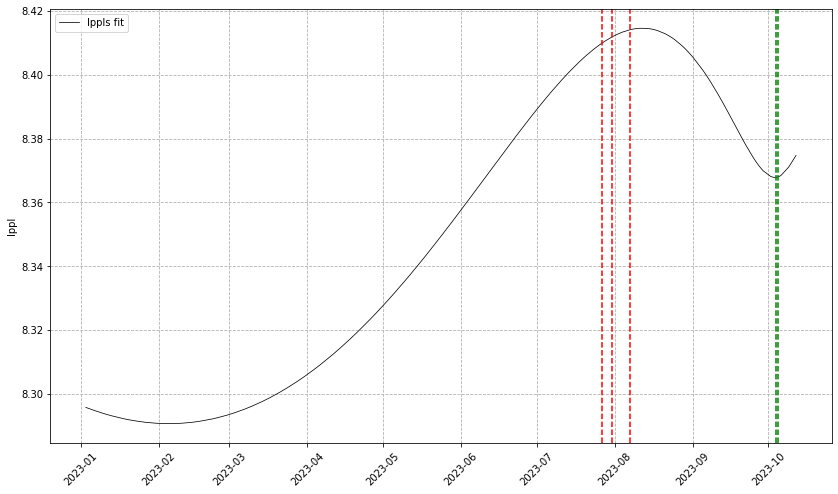

In [106]:
## plots
fig, (ax2) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(14, 8))

ax2.plot(timestamps, lppls_fit , label='lppls fit', color='black', linewidth=0.75)
ax2.grid(which='major', axis='both', linestyle='--')

# set labels
ax2.set_ylabel('lppl')
ax2.legend(loc=2)

# plot confidence poins
for x in pos_indices:
    cof_time = pd.Timestamp.fromordinal(x)
    ax2.axvline(x=cof_time, color='red', linestyle='--', label='Positive confidence')
for x in neg_indices:
    cof_time = pd.Timestamp.fromordinal(x)
    ax2.axvline(x=cof_time, color='green', linestyle='--', label='Negative confidence')

plt.xticks(rotation=45);

In [108]:
max_p = np.max(res_df[res_df['pos_conf']>0.0].pos_conf)
print(max_p)
max_n = np.max(res_df[res_df['neg_conf']>0.0].neg_conf)
print(max_n)

0.5
0.09090909090909091


Time of positive cofficient
2023-07-27 00:00:00
2023-07-31 00:00:00
2023-08-07 00:00:00
Time of negative cofficient
2023-10-05 00:00:00


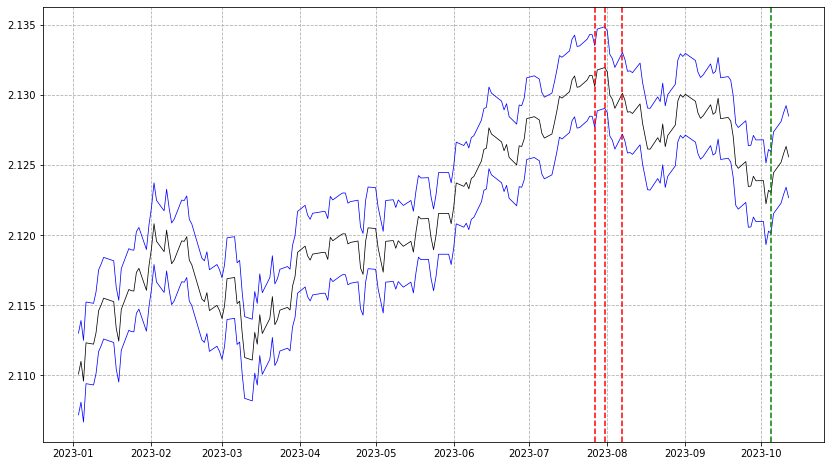

In [111]:
pos_indices = np.array(res_df[res_df['pos_conf']==max_p].time).astype(int)
neg_indices = np.array(res_df[res_df['neg_conf']==max_n].time).astype(int)

fig, (ax3) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(14, 8))

#plot log of price
ax3.plot(timestamps , np.log(price), label='ln(price)', color='black', linewidth=0.75)
ax3.plot(timestamps , np.log(price) + (np.std(np.log(price)))/2, label='upper', color='blue', linewidth=0.75)
ax3.plot(timestamps , np.log(price) - (np.std(np.log(price)))/2, label='lower', color='blue', linewidth=0.75)
ax3.grid(which='major', axis='both', linestyle='--')


# plot confidence poins
print("Time of positive cofficient")
for x in pos_indices:
    cof_time = pd.Timestamp.fromordinal(x)
    ax3.axvline(x=cof_time, color='red', linestyle='--', label='Positive confidence')
    print(cof_time)
print("Time of negative cofficient")
for x in neg_indices:
    cof_time = pd.Timestamp.fromordinal(x)
    ax3.axvline(x=cof_time, color='green', linestyle='--', label='Negative confidence')
    print(cof_time)